In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 파일 경로
FILE1 = "exercise1_distribution.csv"
FILE2 = "exercise2_shuffle.csv"

def load_csv(path: str) -> pd.DataFrame:
    """Load CSV and parse timestamp."""
    df = pd.read_csv(path)
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df = df.sort_values("timestamp").reset_index(drop=True)
    return df

#### 1번 - 전체 vs 시간대별

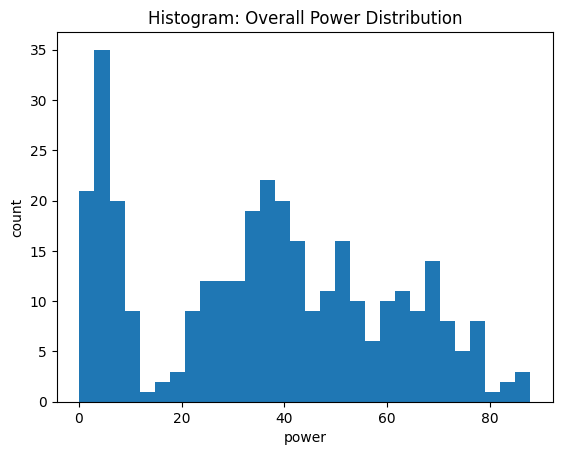

In [9]:
df = load_csv(FILE1)

# 시간대 컬럼 만들기
df["hour"] = df["timestamp"].dt.hour
df["is_night"] = df["hour"] < 6 # 예시: 0 ~ 5시는 야간

# 1) 전체 히스토그램
plt.figure()
plt.hist(df["power"], bins=30)
plt.title("Histogram: Overall Power Distribution")
plt.xlabel("power")
plt.ylabel("count")
plt.show()

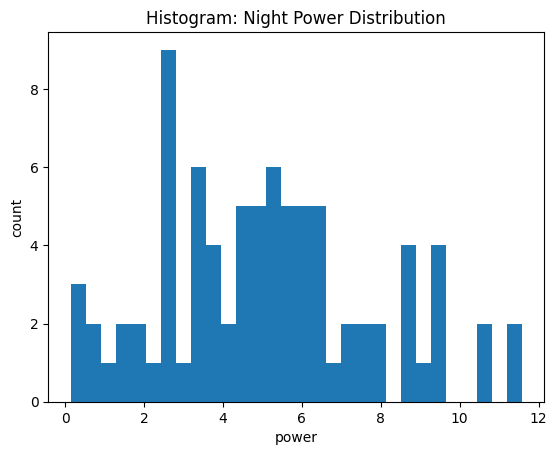

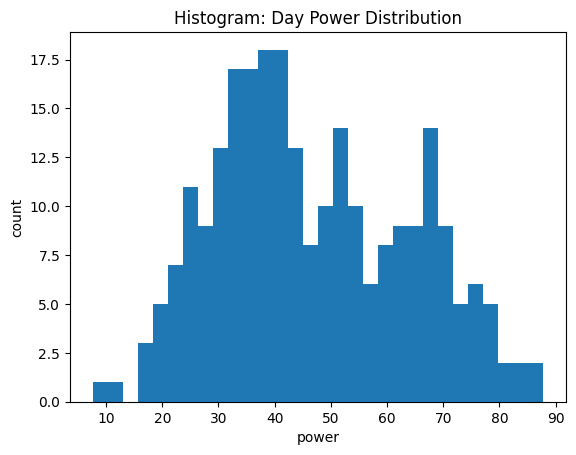

In [ ]:
# 야간 히스토그램
plt.figure()
plt.hist(df[df["is_night"]]["power"], bins=30)
plt.title("Histogram: Night(0~5h) Power Distribution")
plt.xlabel("power")
plt.ylabel("count")
plt.show()

# 주간 히스토그램
plt.hist(df[~df["is_night"]]["power"], bins=30)
plt.title("Histogram: Day(6~23h) Power Distribution")
plt.xlabel("power")
plt.ylabel("count")
plt.show()

#### 2번 - 시간 섞기 vs 시간 유지

In [18]:
df = load_csv(FILE2)

# 기본 파생변수
df["hour"] = df["timestamp"].dt.hour
df["day"] = df["timestamp"].dt.date
print(df.head())
print(df.shape)

# 시간대 평균 예측기
# 훈련 데이터에서 hour별 평균 발전량을 만든다
# 테스트 데이터는 해당 hour 평균값으로 예측

# MAE (평균 절대 오차)
# 실제 값과 예측 값의 차이를 평균내어 예측 오차의 크기를 계산
def mae(y_true, y_pred) -> float:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return float(np.mean(np.abs(y_true - y_pred)))

def fit_hour_mean(train_df: pd.DataFrame) -> dict:
    # hour 별 평균 power
    hour_mean = train_df.groupby("hour")["power"].mean().to_dict()
    return hour_mean

            timestamp     power  hour         day
0 2024-01-01 00:00:00  2.523508     0  2024-01-01
1 2024-01-01 01:00:00  4.035842     1  2024-01-01
2 2024-01-01 02:00:00  6.238794     2  2024-01-01
3 2024-01-01 03:00:00  3.308826     3  2024-01-01
4 2024-01-01 04:00:00  2.533339     4  2024-01-01
(336, 4)


#### 비교 1 - 시간 순서 유지 분할 (정상적인 평가)
시간 기반 분할
- 앞 80%: 훈련
- 뒤 20%: 테스트

In [ ]:
def time_split(df: pd.DataFrame, train_ratio=0.8):
    split = int(len(df) * train_ratio)
    train = df.iloc[:split].copy()
    test = df.iloc[split:].copy()
    return train, test

train_t, test_t = time_split(df, 0.8)

def predict_hour_mean(test_df: pd.DataFrame, hour_mean: dict) -> np.ndarray:
    # hour 별 평균이 없는 경우 전체 평균으로 대체
    global_mean = np.mean(list(hour_mean.values()))
    return test_df["hour"].map(lambda h: hour_mean.get(h, global_mean)).to_numpy()

hour_mean_t = fit_hour_mean(train_t)
pred_t = predict_hour_mean(test_t, hour_mean_t)

mae_t = mae(test_t["power"], pred_t)
print("MAE (time-based split):", round(mae_t, 3)) # MAE (time-based split): 6.088

MAE (time-based split): 6.088


#### 비교 2 - 랜덤 셔플 분할
랜덤 셔플 분할
- 데이터를 섞은 뒤 80/20 분할
- 시계열 데이터에서는 미래 정보가 섞일 위험이 있음
- 성능이 좋아 보이는 착시가 발생할 수 있다

In [ ]:
def random_split(df: pd.DataFrame, train_ratio=0.8, seed=42):
    shuffled = df.sample(frac=1, random_state=seed).reset_index(drop=True)
    split = int(len(shuffled) * train_ratio)
    train = shuffled.iloc[:split].copy()
    test = shuffled.iloc[split:].copy()
    return train, test

train_s, test_s = random_split(df, 0.8, seed=42)

hour_mean_s = fit_hour_mean(train_s)
pred_s = predict_hour_mean(test_s, hour_mean_s)

mae_s = mae(test_s["power"], pred_s)
print("MAE (random shuffle split):", round(mae_s, 3)) # MAE (random shuffle split): 6.607


MAE (random shuffle split): 6.607
